# Introduction to Classification

The goal of this tutorial is to introduce you to the scikit libraries for classification. We will also cover the topic of feature normalization, and evaluation.

In [ ]:
import numpy as np
import scipy.sparse as sp_sparse

import matplotlib.pyplot as plt

import sklearn as sk
import sklearn.datasets as sk_data
import sklearn.metrics as metrics
from sklearn import preprocessing

import seaborn as sns

%matplotlib inline

## Feature normalization##

Python provides some functionality for normalizing and standardizing the data. Be careful though, some operations work only with dense data.

http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing

Normalize by removing the mean and dividing by the standard deviation. This is done per **feature**, that is, per column of the dataset.

In [2]:
X = np.array([[ 1., -1.,  2.],
              [ 2.,  0.,  1.],
              [ 0.,  1., -1.]])
print(X.mean(axis = 0))
print(X.std(axis = 0))
X_scaled = preprocessing.scale(X)
print(X_scaled)
print(X_scaled.mean(axis=0))
print(X_scaled.var(axis = 0))

[ 1.          0.          0.66666667]
[ 0.81649658  0.81649658  1.24721913]
[[ 0.         -1.22474487  1.06904497]
 [ 1.22474487  0.          0.26726124]
 [-1.22474487  1.22474487 -1.33630621]]
[  0.00000000e+00   0.00000000e+00   1.48029737e-16]
[ 1.  1.  1.]


In [8]:
import scipy.sparse
cX = scipy.sparse.csc_matrix(X)
cX_scaled = preprocessing.scale(cX)
print(cX_scaled)

ValueError: Cannot center sparse matrices: pass `with_mean=False` instead See docstring for motivation and alternatives.

The same can be done with the **StandardScaler** from the preprocessing library of sklearn.

The function **fit()** computes the parameters for scaling, and **transform()** applies the scaling

In [9]:
from sklearn import preprocessing
std_scaler = preprocessing.StandardScaler().fit(X)
print(std_scaler.mean_)
print(std_scaler.scale_)
X_std = std_scaler.transform(X)
print(X_std)

[ 1.          0.          0.66666667]
[ 0.81649658  0.81649658  1.24721913]
[[ 0.         -1.22474487  1.06904497]
 [ 1.22474487  0.          0.26726124]
 [-1.22474487  1.22474487 -1.33630621]]


The advantage is the we can now apply the transform to new data.

For example, we compute the parameters for the training data and we apply the scaling to the test data.

In [10]:
y = np.array([[2.,3.,1.],
              [1.,2.,1.]])
print(std_scaler.transform(y))

[[ 1.22474487  3.67423461  0.26726124]
 [ 0.          2.44948974  0.26726124]]


The **MinMaxScaler** subbtracts from each column the minimum and then divides by the max-min.

In [14]:
min_max_scaler = preprocessing.MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(X)
print(X_minmax)
print(min_max_scaler.transform(y))

[[ 0.5         0.          1.        ]
 [ 1.          0.5         0.66666667]
 [ 0.          1.          0.        ]]
[[ 1.          2.          0.66666667]
 [ 0.5         1.5         0.66666667]]


The **MaxAbsScaler** divides with the maximum absolute value. 

The MaxAbsScaler can work with sparse data, since it does not destroy the data sparseness. For the other datasets, removing the mean (or min) can destroy the sparseness of the data. 

Sometimes we may choose to normalize only the non-zero values. This should be done manually.

In [15]:
# works with sparse data
max_abs_scaler = preprocessing.MaxAbsScaler()
X_maxabs = max_abs_scaler.fit_transform(X)
X_maxabs

array([[ 0.5, -1. ,  1. ],
       [ 1. ,  0. ,  0.5],
       [ 0. ,  1. , -0.5]])

In [17]:
cX_scaled = max_abs_scaler.transform(cX)
print(cX_scaled)

  (0, 0)	0.5
  (1, 0)	1.0
  (0, 1)	-1.0
  (2, 1)	1.0
  (0, 2)	1.0
  (1, 2)	0.5
  (2, 2)	-0.5


The **normalize** function normalizes the **rows** so that they become unit vectors in some norm that we specify. It can be applied to sparse matrices without destroying the sparsity.

In [18]:
#works with sparse data

X_normalized = preprocessing.normalize(X, norm='l2')

X_normalized                                      

array([[ 0.40824829, -0.40824829,  0.81649658],
       [ 0.89442719,  0.        ,  0.4472136 ],
       [ 0.        ,  0.70710678, -0.70710678]])

In [19]:
crX = scipy.sparse.csr_matrix(X)
crX_scaled = preprocessing.normalize(crX,norm='l1')
print(crX_scaled)

  (0, 0)	0.25
  (0, 1)	-0.25
  (0, 2)	0.5
  (1, 0)	0.666666666667
  (1, 2)	0.333333333333
  (2, 1)	0.5
  (2, 2)	-0.5


### OneHotEncoder

The **OneHotEncoder** can be used for categorical data to transform them into binary, where for each attribute value we have 0 or 1 depending on whether this value appears in the feature vector. It works with numerical categorical values.

In [20]:
X = [[0,1,2],
     [1,2,3],
     [0,1,4]]
enc = preprocessing.OneHotEncoder()
enc.fit(X)
enc.transform([[0,2,4],[1,1,2]]).toarray()

array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.],
       [ 0.,  1.,  1.,  0.,  1.,  0.,  0.]])

We can also apply it selectively to some columns of the data

In [21]:
#works with sparse data

X = [[0, 10, 45100],
     [1, 20, 45221],
     [0, 20, 45212]]
enc = preprocessing.OneHotEncoder(categorical_features=[2]) #only the third column is categorical
enc.fit(X)
enc.transform([[5,13,45212],[4,12,45221]]).toarray()

array([[  0.,   1.,   0.,   5.,  13.],
       [  0.,   0.,   1.,   4.,  12.]])

## Feature Selection##

Feature selection is about finding the best features for your classifier. This may be important if you do not have enough training data. The idea is to find metrics that either characterize the features by themselves, or with respect to the class we want to predict, or with respect to other features.

http://scikit-learn.org/stable/modules/feature_selection.html

The **VarianceThreshold** selection drops features whose variance is below some threshold. If we have binary features we can estimate the treshold exactly so as to guarantee a specific ratio of 0's and 1's

In [22]:
from sklearn.feature_selection import VarianceThreshold
X = [[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]
print(np.array(X))
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)

[[0 0 1]
 [0 1 0]
 [1 0 0]
 [0 1 1]
 [0 1 0]
 [0 1 1]]


array([[0, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1]])

A more sophisticated feature selection technique uses the chi-square test to determine if a feature and the class label are independent.

https://en.wikipedia.org/wiki/Chi-squared_test

In this case the feature will have high score and low p-value. The features with the lowest values are rejected.

The chi-square test is usually applied on categorical data.

In [23]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
iris = load_iris()
X, y = iris.data, iris.target
print(X.shape)
print(X[1:10,:],y[1:10])
sel = SelectKBest(chi2, k=2)
X_new = sel.fit_transform(X, y)
print(X_new[1:10])
print(sel.scores_)
c,p = sk.feature_selection.chi2(X, y)
print(c) #The chi-square value between X columns and y
print(p) #The p-value for the test

(150, 4)
[[ 4.9  3.   1.4  0.2]
 [ 4.7  3.2  1.3  0.2]
 [ 4.6  3.1  1.5  0.2]
 [ 5.   3.6  1.4  0.2]
 [ 5.4  3.9  1.7  0.4]
 [ 4.6  3.4  1.4  0.3]
 [ 5.   3.4  1.5  0.2]
 [ 4.4  2.9  1.4  0.2]
 [ 4.9  3.1  1.5  0.1]] [0 0 0 0 0 0 0 0 0]
[[ 1.4  0.2]
 [ 1.3  0.2]
 [ 1.5  0.2]
 [ 1.4  0.2]
 [ 1.7  0.4]
 [ 1.4  0.3]
 [ 1.5  0.2]
 [ 1.4  0.2]
 [ 1.5  0.1]]
[  10.81782088    3.59449902  116.16984746   67.24482759]
[  10.81782088    3.59449902  116.16984746   67.24482759]
[  4.47651499e-03   1.65754167e-01   5.94344354e-26   2.50017968e-15]


## Classification models

http://scikit-learn.org/stable/supervised_learning.html#supervised-learning

Python has classes and objects that implement the different classification techniques that we described in class. 

Regardless of the choice of classifier, each classifier has two methods:

The method **fit()** takes the training data and labels, and trains the model

The method **predict()** takes as input the test data and applies the model. 

### Preparing the data###

Here we load the data, randomly shuffle it, and select a part of the data for training and a part for testing

In [24]:
from sklearn.datasets import load_iris
import sklearn.utils as utils

iris = load_iris()
print(iris.data[:5,:])
print(iris.target)
print(iris.target_names)
X, y = utils.shuffle(iris.data, iris.target, random_state=1) #shuffle the data
print(X.shape)
print(y.shape)
print(y)

[[ 5.1  3.5  1.4  0.2]
 [ 4.9  3.   1.4  0.2]
 [ 4.7  3.2  1.3  0.2]
 [ 4.6  3.1  1.5  0.2]
 [ 5.   3.6  1.4  0.2]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
['setosa' 'versicolor' 'virginica']
(150, 4)
(150,)
[0 1 1 0 2 1 2 0 0 2 1 0 2 1 1 0 1 1 0 0 1 1 1 0 2 1 0 0 1 2 1 2 1 2 2 0 1
 0 1 2 2 0 2 2 1 2 0 0 0 1 0 0 2 2 2 2 2 1 2 1 0 2 2 0 0 2 0 2 2 1 1 2 2 0
 1 1 2 1 2 1 0 0 0 2 0 1 2 2 0 0 1 0 2 1 2 2 1 2 2 1 0 1 0 1 1 0 1 0 0 2 2
 2 0 0 1 0 2 0 2 2 0 2 0 1 0 1 1 0 0 1 0 1 1 0 1 1 1 1 2 0 0 2 1 2 1 2 2 1
 2 0]


In [25]:
train_set_size = 100
X_train = X[:train_set_size]  # selects first 100 rows (examples) for train set
y_train = y[:train_set_size]
X_test = X[train_set_size:]   # selects from row 100 until the last one for test set
y_test = y[train_set_size:]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(100, 4) (100,)
(50, 4) (50,)


### Decision Trees###
http://scikit-learn.org/stable/modules/tree.html

In [26]:
from sklearn import tree

dtree = tree.DecisionTreeClassifier()
dtree = dtree.fit(X_train, y_train)
print(dtree.score(X_test,y_test))

y_pred = dtree.predict(X_test)
y_prob = dtree.predict_proba(X_test)
print(y_pred[:10])
print(y_prob[:10])
print(metrics.accuracy_score(y_test,y_pred))
print(metrics.confusion_matrix(y_test,y_pred))
print(metrics.precision_score(y_test,y_pred,average=None))
print(metrics.precision_score(y_test,y_pred,average='weighted'))
print(metrics.recall_score(y_test,y_pred,average=None))
print(metrics.recall_score(y_test,y_pred,average='weighted'))
print(metrics.f1_score(y_test,y_pred,average=None))
print(metrics.f1_score(y_test,y_pred,average='weighted'))

0.88
[0 1 0 1 1 0 1 0 0 2]
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]]
0.88
[[19  0  0]
 [ 0 16  2]
 [ 0  4  9]]
[ 1.          0.8         0.81818182]
0.880727272727
[ 1.          0.88888889  0.69230769]
0.88
[ 1.          0.84210526  0.75      ]
0.878157894737


In [27]:
print(dtree.tree_)
from inspect import getmembers
print( getmembers( dtree.tree_ ) )

[('__class__', <class 'sklearn.tree._tree.Tree'>), ('__delattr__', <method-wrapper '__delattr__' of sklearn.tree._tree.Tree object at 0x00000295ACDEC6B0>), ('__dir__', <built-in method __dir__ of sklearn.tree._tree.Tree object at 0x00000295ACDEC6B0>), ('__doc__', "Array-based representation of a binary decision tree.\n\n    The binary tree is represented as a number of parallel arrays. The i-th\n    element of each array holds information about the node `i`. Node 0 is the\n    tree's root. You can find a detailed description of all arrays in\n    `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split\n    nodes, resp. In this case the values of nodes of the other type are\n    arbitrary!\n\n    Attributes\n    ----------\n    node_count : int\n        The number of nodes (internal nodes + leaves) in the tree.\n\n    capacity : int\n        The current capacity (i.e., size) of the arrays, which is at least as\n        great as `node_count`.\n\n    max_depth : int\n  

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


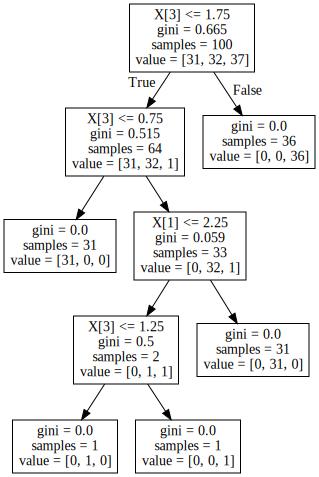

In [30]:
import graphviz 
print(iris.feature_names)
dot_data = tree.export_graphviz(dtree,out_file=None)
graph = graphviz.Source(dot_data)
graph

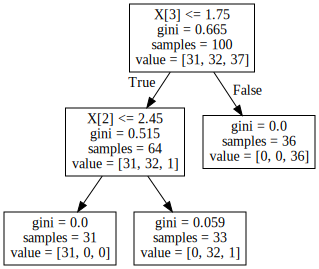

In [29]:
from sklearn import tree
import graphviz 

dtree2 = tree.DecisionTreeClassifier(max_depth=2)
dtree2 = dtree2.fit(X_train, y_train)
dot_data2 = tree.export_graphviz(dtree2,out_file=None)
graph2 = graphviz.Source(dot_data2)
graph2


### k-NN Classification ###

http://scikit-learn.org/stable/modules/neighbors.html

In [31]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
print(knn.score(X_test,y_test))

y_pred = knn.predict(X_test)
print(metrics.confusion_matrix(y_test,y_pred))

print(metrics.precision_score(y_test,y_pred,average=None))
print(metrics.precision_score(y_test,y_pred,average='weighted'))
print(metrics.recall_score(y_test,y_pred,average=None))
print(metrics.recall_score(y_test,y_pred,average='weighted'))
print(metrics.f1_score(y_test,y_pred,average=None))
print(metrics.f1_score(y_test,y_pred,average='weighted'))

0.94
[[19  0  0]
 [ 0 16  2]
 [ 0  1 12]]
[ 1.          0.94117647  0.85714286]
0.941680672269
[ 1.          0.88888889  0.92307692]
0.94
[ 1.          0.91428571  0.88888889]
0.940253968254


### SVM Classification###

http://scikit-learn.org/stable/modules/svm.html

http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

In [32]:
from sklearn import svm

#svm_clf = svm.LinearSVC()
#svm_clf = svm.SVC(kernel = 'poly')
svm_clf = svm.SVC()
svm_clf.fit(X_train,y_train)
print(svm_clf.score(X_test,y_test))
y_pred = svm_clf.predict(X_test)
print(metrics.confusion_matrix(y_test,y_pred))

print(metrics.precision_score(y_test,y_pred,average=None))
print(metrics.precision_score(y_test,y_pred,average='weighted'))
print(metrics.recall_score(y_test,y_pred,average=None))
print(metrics.recall_score(y_test,y_pred,average='weighted'))
print(metrics.f1_score(y_test,y_pred,average=None))
print(metrics.f1_score(y_test,y_pred,average='weighted'))

0.98
[[19  0  0]
 [ 0 18  0]
 [ 0  1 12]]
[ 1.          0.94736842  1.        ]
0.981052631579
[ 1.          1.          0.92307692]
0.98
[ 1.          0.97297297  0.96      ]
0.97987027027


### Logistic Regression ###

http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression

In [33]:
import sklearn.linear_model as linear_model

lr_clf = linear_model.LogisticRegression()
lr_clf.fit(X_train, y_train)
print(lr_clf.score(X_test,y_test))
y_pred = lr_clf.predict(X_test)
print(metrics.confusion_matrix(y_test,y_pred))
print(metrics.precision_score(y_test,y_pred,average=None))
print(metrics.precision_score(y_test,y_pred,average='weighted'))
print(metrics.recall_score(y_test,y_pred,average=None))
print(metrics.recall_score(y_test,y_pred,average='weighted'))
print(metrics.f1_score(y_test,y_pred,average=None))
print(metrics.f1_score(y_test,y_pred,average='weighted'))


0.96
[[19  0  0]
 [ 0 16  2]
 [ 0  0 13]]
[ 1.          1.          0.86666667]
0.965333333333
[ 1.          0.88888889  1.        ]
0.96
[ 1.          0.94117647  0.92857143]
0.96025210084


In [34]:
probs = lr_clf.predict_proba(X_test)
print (probs)
print (probs.argmax(axis = 1))
print (probs.max(axis = 1))

[[  9.42848537e-01   5.71375773e-02   1.38860506e-05]
 [  7.36901098e-02   7.22694123e-01   2.03615768e-01]
 [  7.11546818e-01   2.87755584e-01   6.97598209e-04]
 [  4.89825361e-02   7.17197031e-01   2.33820433e-01]
 [  1.81245540e-02   6.43677875e-01   3.38197571e-01]
 [  8.56222465e-01   1.43598825e-01   1.78709592e-04]
 [  1.32661219e-02   6.69340523e-01   3.17393355e-01]
 [  8.90737869e-01   1.09004746e-01   2.57384935e-04]
 [  7.99367919e-01   2.00379203e-01   2.52878017e-04]
 [  1.26409293e-03   1.57157352e-01   8.41578555e-01]
 [  2.49910290e-03   2.46064318e-01   7.51436579e-01]
 [  6.39100774e-04   2.24939995e-01   7.74420904e-01]
 [  8.33706116e-01   1.66210803e-01   8.30810191e-05]
 [  8.94412871e-01   1.05503577e-01   8.35520171e-05]
 [  9.72020748e-03   3.00444130e-01   6.89835663e-01]
 [  7.98905301e-01   2.00868235e-01   2.26463968e-04]
 [  1.60403736e-03   2.95399378e-01   7.02996584e-01]
 [  7.87969440e-01   2.11818459e-01   2.12101017e-04]
 [  2.72568465e-03   2.82704

## Evaluation##

http://scikit-learn.org/stable/model_selection.html#model-selection

### Computing Scores###

In [35]:
p,r,f,s = metrics.precision_recall_fscore_support(y_test,y_pred)
print(p)
print(r)
print(f)


[ 1.          1.          0.86666667]
[ 1.          0.88888889  1.        ]
[ 1.          0.94117647  0.92857143]


In [36]:
report = metrics.classification_report(y_test,y_pred)
print(report)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        19
          1       1.00      0.89      0.94        18
          2       0.87      1.00      0.93        13

avg / total       0.97      0.96      0.96        50



[0 1 0 1 1 0 1 0 0 2 2 2 0 0 1 0 2 0 2 2 0 2 0 1 0 1 1 0 0 1 0 1 1 0 1 1 1
 1 2 0 0 2 1 2 1 2 2 1 2 0]
[0 1 0 1 1 0 1 0 0 2 2 2 0 0 1 0 2 0 2 2 0 2 0 1 0 1 1 0 0 1 0 1 1 0 1 1 1
 1 2 0 0 2 1 2 1 2 2 1 2 0]
[ 1.          0.92307692  0.84615385  0.76923077  0.69230769  0.69230769
  0.61538462  0.46153846  0.38461538  0.30769231  0.23076923  0.15384615
  0.07692308  0.        ]
[ 0.92857143  0.92307692  0.91666667  0.90909091  0.9         1.          1.
  1.          1.          1.          1.          1.          1.          1.        ]
[ 0.53243307  0.53549023  0.56214494  0.67046443  0.68983566  0.69214247
  0.70299658  0.71456963  0.75143658  0.7744209   0.8021862   0.81378803
  0.84157856]
0.991683991684


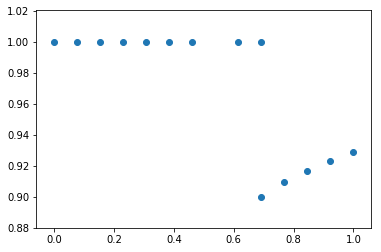

In [37]:
#y_true = np.array([0, 0, 1, 1])
y_true = np.array(y_test)
print(y_true)
print(y_test)
y_true[y_true != 2] = 0
y_true[y_true==2] = 1
#y_scores = np.array([0.1, 0.4, 0.35, 0.8])
y_scores = probs[:,2]
precision, recall, thresholds = metrics.precision_recall_curve(y_true,y_scores)
plt.scatter(recall,precision)
print(recall)
print(precision)
print(thresholds)
fpr, tpr, ths = metrics.roc_curve(y_true,y_scores)
print(metrics.roc_auc_score(y_true,y_scores))

[[  8.45092914e-01   1.54907086e-01]
 [  9.99986461e-01   1.35387408e-05]
 [  1.86410469e-03   9.98135895e-01]
 [  7.19296692e-06   9.99992807e-01]
 [  7.69377078e-04   9.99230623e-01]
 [  2.46954912e-01   7.53045088e-01]
 [  3.83185594e-03   9.96168144e-01]
 [  9.97436461e-01   2.56353912e-03]
 [  9.87310275e-01   1.26897245e-02]
 [  6.68878808e-03   9.93311212e-01]
 [  1.20824092e-04   9.99879176e-01]
 [  9.48775721e-01   5.12242791e-02]
 [  7.07352926e-01   2.92647074e-01]
 [  9.98429120e-01   1.57087955e-03]
 [  9.79761333e-01   2.02386674e-02]
 [  2.06536170e-03   9.97934638e-01]
 [  2.97926888e-01   7.02073112e-01]
 [  4.94170630e-01   5.05829370e-01]
 [  1.21516137e-03   9.98784839e-01]
 [  9.98261314e-01   1.73868570e-03]
 [  9.92486607e-01   7.51339344e-03]
 [  9.92981490e-01   7.01850976e-03]
 [  1.76058441e-01   8.23941559e-01]
 [  2.14806280e-03   9.97851937e-01]
 [  9.77064059e-01   2.29359410e-02]
 [  3.39512180e-03   9.96604878e-01]
 [  4.09388105e-03   9.95906119e-01]
 

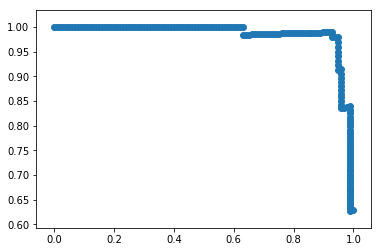

In [38]:
(Xtoy,y_toy)=sk_data.make_classification(n_samples=1000)
Xttrain = Xtoy[:800,:]
Xttest = Xtoy[800:,:]
yttrain = y_toy[:800]
yttest = y_toy[800:]

lr_clf.fit(Xttrain, yttrain)
#print(lr_clf.score(Xttest,yttest))
#y_tpred = lr_clf.predict(X_test)
tprobs = lr_clf.predict_proba(Xttest)
print (tprobs)

y_tscores = tprobs[:,1]
precision, recall, thresholds = metrics.precision_recall_curve(yttest,y_tscores)
plt.scatter(recall,precision)

### k-fold cross validation ###

http://scikit-learn.org/stable/modules/cross_validation.html

http://scikit-learn.org/stable/modules/cross_validation.html#k-fold

In [43]:
import sklearn.cross_validation as cross_validation

scores = cross_validation.cross_val_score(#lr_clf,
                                          #svm_clf,
                                          #knn,
                                          dtree,
                                          X,
                                          y,
                                          scoring='accuracy',
                                          cv=3)
print (scores)
print (scores.mean())

[ 0.96078431  0.98039216  0.875     ]
0.938725490196
